Test Jacobi-iterator for elastic problems using MFEANet

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from functools import reduce

from utils import plot
import feanet.pac as pac
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from data.dataset import MechanicalDataSet

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
bs = 1 # batch size
k = 0 # test data index
n_test = 2**6
test_set = MechanicalDataSet('data/data_Ti64/elastic_Ti64.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
mask_test, dirich_idx_test, dirich_value_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))
solution_test, f_test, d_test, d_idx_test, t_test, t_conn_test, m_test, msk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(mask_test[k], 0).to(device_predict))

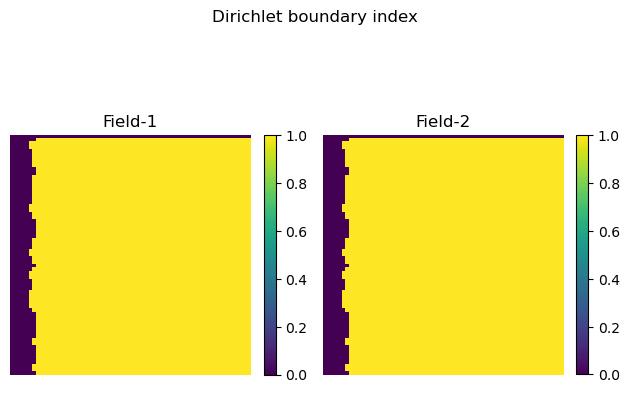

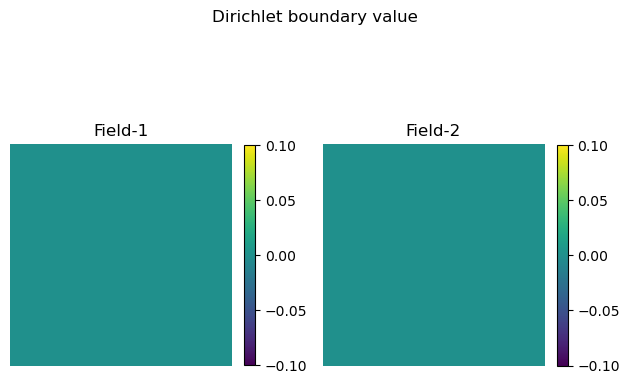

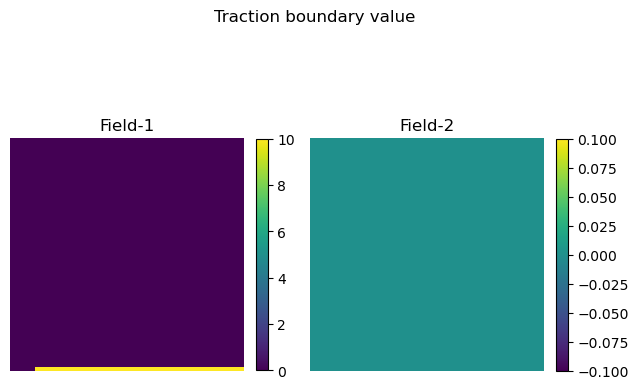

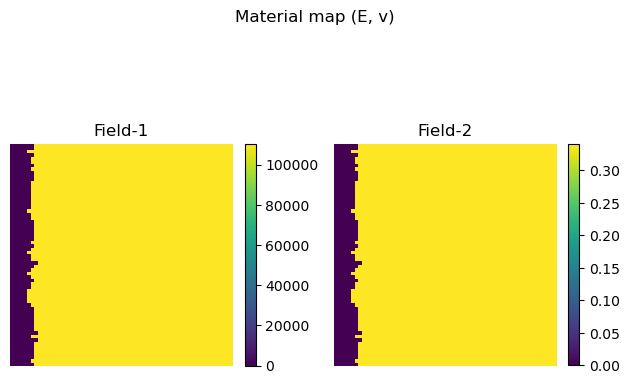

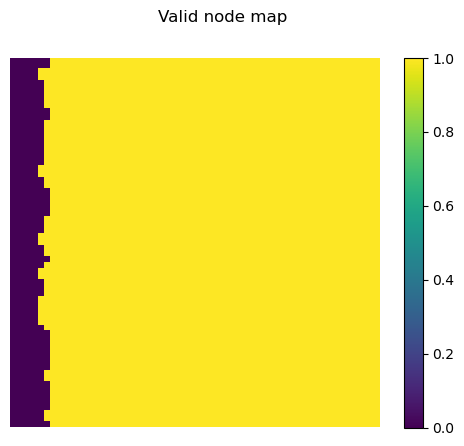

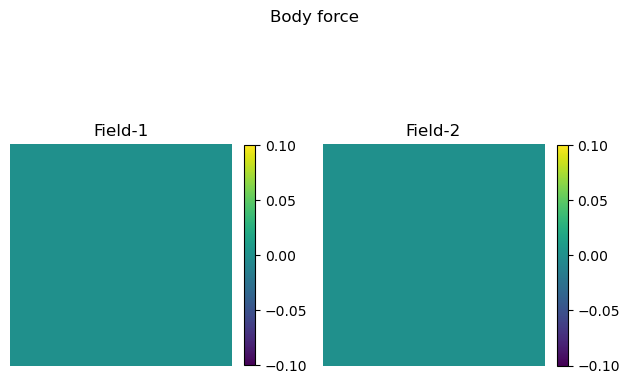

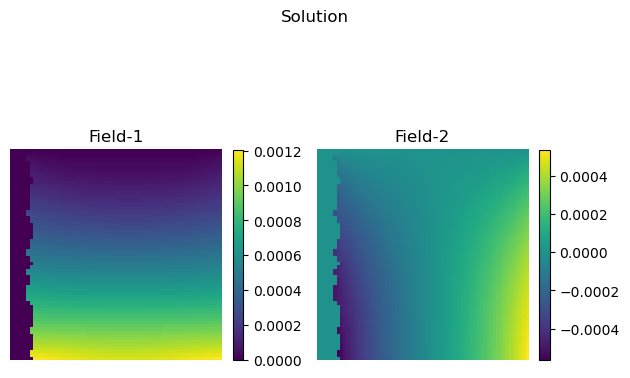

In [4]:
plot.plot_elasticfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_elasticfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Traction boundary value')
plot.plot_elasticfield(material_test[k], ftitle='Material map (E, v)')
plot.plot_thermalfield(mask_test[k], ftitle='Valid node map')
plot.plot_elasticfield(f_test[k], ftitle='Body force')
plot.plot_elasticfield(u_test[k], ftitle='Solution')

In [5]:
n_elem = n_test
ku, kf = 2, 2
h = 0.0061*4
grid = SingleGrid(h, n_elem=n_elem, mode='elastic', dev=device_predict)

In [6]:
EPS = 1e-6
n_jac = 0
jacu_test = EPS*torch.ones(size=(1, ku, n_elem+1, n_elem+1), requires_grad=False, dtype=torch.double).to(device_predict)
jacu_test = grid.jac.reset_boundary(jacu_test, d_test, d_idx_test)
residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
res = torch.norm(residual).item() 
res_arr = [res]

if (False):
    print(n_jac, res)
    while (abs(res) > EPS):
        jacu_test = grid.jac.jacobi_convolution(jacu_test, m_test, msk_test, d_test, d_idx_test, None, None, h, f_test, t_test, t_conn_test)
        residual = grid.net(None, None, h, jacu_test, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
        res = torch.norm(residual).item() 
        res_arr.append(res)
        n_jac += 1
        print(n_jac, res)

    print("Solution converges after", n_jac, "Jacobi iterations ")

    plt.plot(res_arr)
    plt.yscale('log')
    plt.show()

    plot.plot_elasticfield(jacu_test[0], "Benchmark")
    plot.plot_elasticfield(solution_test[0], "Test")
    plot.plot_elasticfield(jacu_test[0]-solution_test[0], 'Error')

0 2.0887481412266125
1 4.125884328029745
2 3.5034200374338473
3 3.9450205476200977
4 3.933213838162325
5 3.9482032067805277
6 3.8997198478160997
7 3.8389805727259865
8 3.766287055186999
9 3.6899059076399623
10 3.6122175021489067
11 3.5351693507909947
12 3.4596226873705875
13 3.386048823512904
14 3.3146303191131508
15 3.2454065977572375
16 3.178334616550118
17 3.11333102414734
18 3.0502944381468153
19 2.9891185159579305
20 2.9296988904659447
21 2.8719367259585917
22 2.815740271398779
23 2.7610253035001797
24 2.7077149655547776
25 2.655739303797468
26 2.605034673221024
27 2.5555431096097645
28 2.5072117195120356
29 2.459992113737149
30 2.41383989493087
31 2.368714201440629
32 2.324577305259679
33 2.2813942597225796
34 2.239132591797703
35 2.1977620337293002
36 2.157254289047891
37 2.1175828284166727
38 2.0787227112847235
39 2.0406504298203916
40 2.0033437720693015
41 1.9667817017003795
42 1.930944252085785
43 1.8958124327713965
44 1.8613681466868695
45 1.8275941166728575
46 1.79447382011

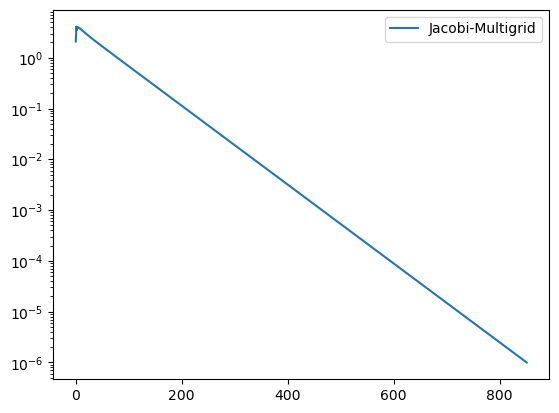

In [7]:
with torch.no_grad():
    n = n_test
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, pacnet=None, device=device, nb_layers=3, mode='elastic', iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(f_test,t_test,t_conn_test,d_test,d_idx_test,m_test,msk_test)
    u_mg_jac = EPS*torch.ones((1, ku, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_mgjac = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, f_test, t_test, t_conn_test, m_test, msk_test)
        res = torch.norm(residual).item()
        res_arr_mgjac.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')
    
plt.plot(res_arr_mgjac, label='Jacobi-Multigrid')
plt.yscale('log')
plt.legend()
plt.show()


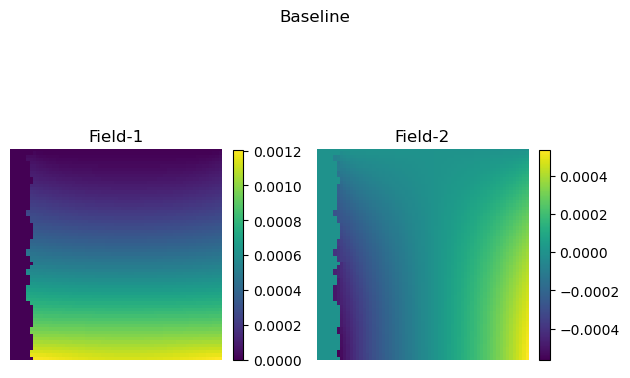

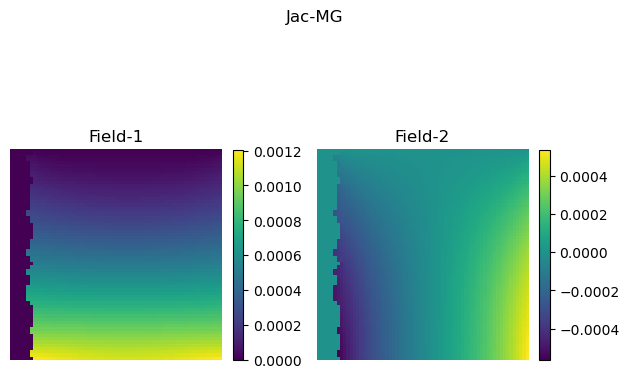

In [8]:
plot.plot_elasticfield(solution_test[k], ftitle='Baseline')
plot.plot_elasticfield(u_mg_jac[k], ftitle='Jac-MG')